In [2]:

import numpy as np
import matplotlib.pyplot as plt
# If you need to import from a local utils.py, uncomment and adjust the following lines:
import sys
import os
import jax.numpy as jnp
from scipy.stats import norm

# Construct the full path to the folder
folder_path = r'C:\Users\Petrb\Desktop\DTU\3rdSemester\02477_BAYESIAN_MACHINE_LEARNING'

# Add the folder to the Python path
sys.path.append(folder_path)

# Now you can import the utils module
from EXAMS.EXAM_2024.Task_2.utils import *
from utils import *
from kernel_gaussian_classes import *
from Assignment_3 import * 

data = jnp.load('data_exercise5b.npz')
X = data['day']
y = np.log(data['bike_count'])

# remove mean and scale to unit variance 
ym, ys = jnp.mean(y), jnp.std(y)
y = (y - ym) / ys


import seaborn as snb



snb.set_style('darkgrid')
snb.set(font_scale=1.25)

The Gaussian process regression model for the dataset $\mathcal{D} = \{(x_n, y_n)\}_{n=1}^N$ is given below:

$$
y_n = f(x_n) + \epsilon_n, \quad (1)
$$

where $\epsilon_n \sim \mathcal{N}(0, \sigma^2)$ and $f(x) \sim \mathcal{GP}(0, k(x,x'))$ for $k(x, x') = \kappa^2 \exp\left(-\frac{\|x - x'\|^2}{2\ell^2} \right)$.

We will impose the following prior distributions on the hyperparameters:

$$
\kappa \sim \mathcal{N}_+(0, 1) \\
\ell \sim \mathcal{N}_+(0, v) \\
\sigma \sim \mathcal{N}_+(0, 1),
$$

where $v > 0$ is a positive constant (which you will determine in the next task) and $\mathcal{N}_+(m, v)$ is the half-normal distribution. These assumptions lead to the following joint distribution:

$$
p(y, \mathbf{f}, \sigma, \kappa, \ell) = p(y|\mathbf{f}, \sigma^2)p(\mathbf{f}|\kappa, \ell)p(\kappa)p(\ell)p(\sigma) \\
= \mathcal{N}(y|\mathbf{f}, \sigma^2 I)\mathcal{N}(\mathbf{f}|0, K)\mathcal{N}_+(\kappa|0,1)\mathcal{N}_+(\ell|0,v)\mathcal{N}_+(\sigma|0,1).
$$

In this exercise, we want to impose a prior that prevents the lengthscale from becoming too large.

---

### Task 1.1: 
**Choose a value for $v$ such that the prior probability of observing a lengthscale larger than 100 is approximately 1%, i.e. $p(\ell > 100) \approx 0.01$.**

**Hints:** You can do this in several ways, e.g. numerically or analytically.


I approximate the probability $p(\ell > 100)$ using the Monte Carlo Sampling. Where I sample $\ell \sim \mathcal{N}_+ (0, v)$ and count the number of samples that are greater than 100. $$p(\ell > 100) = \mathbb{E}[\mathbb{I}_{\ell > 100}] = \frac{1}{N} \sum_{i=1}^N \mathbb{I}_{\ell_i > 100} \approx 38.5^2 = 1482.25$$

where $\mathbb{I}_{\ell > 100}$ is the indicator function that is equal to 1 if $\ell > 100$ and 0 otherwise.

In [2]:
def find_the_optimal_ell(num_samples=1000):
    stdv_ell  = jnp.linspace(38.5, 39, 100000)
    
    
    for i in stdv_ell:
        ell_samples = jnp.abs(np.random.normal(0, i, num_samples))
        p_geq_100 = ell_samples[ell_samples > 100]
        
        probability = len(p_geq_100) / num_samples
        if abs(probability - 0.01) < 1e-5:
            
            print(f"Optimal std_dev: {i} with the probability {probability}")
            break
    
find_the_optimal_ell(num_samples=500000)

KeyboardInterrupt: 

---

### Task 1.2: 
**Determine the marginalized distribution $p(y, \sigma, \kappa, \ell)$.**

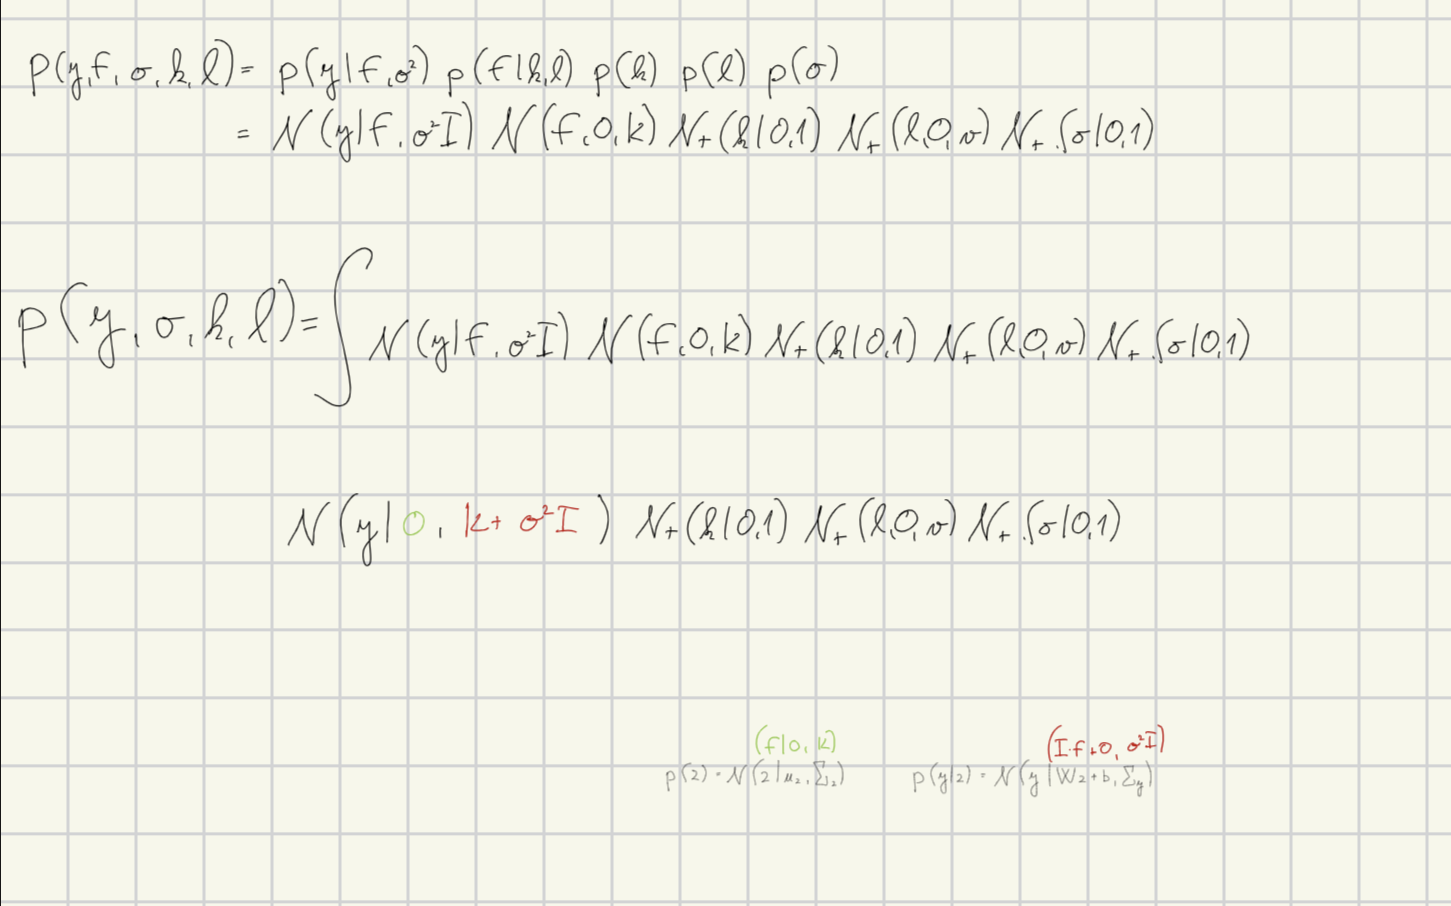


---

The next goal is to approximate the posterior distribution over the hyperparameters, i.e. $p(\kappa, \ell, \sigma | y)$, using a Metropolis-sampler. Define $\theta = \{\kappa, \ell, \sigma^2\}$ to be the set of hyperparameters of the model. Since the scale of the hyperparameters are quite different, we will use an anisotropic proposal distribution:

$$
q(\theta^* | \theta^{k-1}) = \mathcal{N}(\theta^* | \theta^{k-1}, \Sigma) \quad \text{for} \quad 
\Sigma = \frac{1}{2} 
\begin{bmatrix}
1 & 0 & 0 \\
0 & 100 & 0 \\
0 & 0 & 0.01
\end{bmatrix}.
\quad (2)
$$

That is, te proposed step-size will be larger for the lengthscale dimension and so on. 


### Task 1.3: 
**Implement a Metropolis sampler using the proposal distribution in eq. (2) for generating samples from the posterior $p(\kappa, \ell, \sigma \mid y)$. Run 4 chains for 10000 iterations each.**

*Hint: The half-normal distribution can be implemented as follows*

```python
from scipy.stats import norm

def log_halfnormal(x):
    return jnp.log(2) + norm.logpdf(x, 0, 1)

In [3]:
# The half normal distribution 
def log_halfnormal(x, scale):
    return jnp.log(2) + norm.logpdf(x, loc=0, scale=scale)

# Log hyperpriors for the parameters k, ell, and sigma
def log_hyperpriors(thetas):
    k = thetas[0]
    ell = thetas[1]
    sigma = thetas[2]
    # ensure positivity of the parameters
    if jnp.any(thetas <= 0):
        return -jnp.inf
    log_hyp_prior = log_halfnormal(k, 1.0) + log_halfnormal(ell, 38.8) + log_halfnormal(sigma, 1.0)
    return log_hyp_prior

In [4]:
# create kernel function

kernel = StationaryIsotropicKernel(squared_exponential)

# instantiate the Gaussian process regression model
gp = GaussianProcessRegression(X, y, kernel)

# initial values for the hyperparameters
#thetas = jnp.array([0.5, 1.0, 0.5]) 

log_joint_new = lambda thetas: log_hyperpriors(thetas) + gp.log_marginal_likelihood(thetas[0], thetas[1], thetas[2])

#print(f"Log joint new: {log_joint_new(thetas)}")

In [5]:

# Parameters for the MCMC Algorithm 

NUM_ITER = 1000
SIGMA = 0.5 * jnp.array([1.0, 100.0, 0.01])  # Step sizes

WARMUP = int(NUM_ITER * 0.1)
print(f"WARMUP: {WARMUP}")
NU_PARAMS = 3 
NUM_CHAINS = 4
SEEDS = jnp.arange(NUM_CHAINS)
key = random.PRNGKey(1)  
keys = random.split(key, NUM_CHAINS)  # Split the key for each chain
THETA_INIT = jnp.array([5 * np.abs(random.normal(keys[i], shape=(NU_PARAMS,))) for i in range(NUM_CHAINS)])


WARMUP: 100


In [ ]:
chains, accepts  = metropolis_multiple_chains(log_joint_new, NU_PARAMS, NUM_CHAINS, SIGMA, NUM_ITER, THETA_INIT, SEEDS, WARMUP)

Running chain 0. Acceptance ratio: 0.33
Running chain 1. Acceptance ratio: 0.30
Running chain 2. 

---

### Task 1.4: 
**Plot the trace for each parameter and report the convergence diagnostics $\hat{R}$ and $S_{\text{eff}}$ for each parameter. Discard warm-up samples and report the number of samples discarded.**

---

### Task 1.5: 
**Estimate and report the posterior mean for each hyperparameter. Report the MCSE for each estimate.**

---

### Task 1.6: 
**Estimate a 95% posterior credibility interval for each hyperparameter.**


95%-interval of Kappa:  [0.35 1.82]
Posterior Mean and variance and standard deviation of kappa: 0.9383, 0.1352, 0.3677
**************************************************
95%-interval of ell:  [ 26.48 107.9 ]
Posterior Mean and variance of ell: 65.2568, 414.8166, 20.3670
**************************************************
95%-interval of sigma:  [0.55 4.28]
Posterior Mean and variance and standard deviation of sigma: 1.8594, 1.2866, 1.1343
**************************************************
Rhat for all params: [1.1140367 1.0872557 3.9349532]
Total number of samples: 36000
Effective sample size: [47 57  5]
R_eff: [0.00130556 0.00158333 0.00013889]
Monte Carlo error: [0.05362732 2.6976812  0.5072638 ]


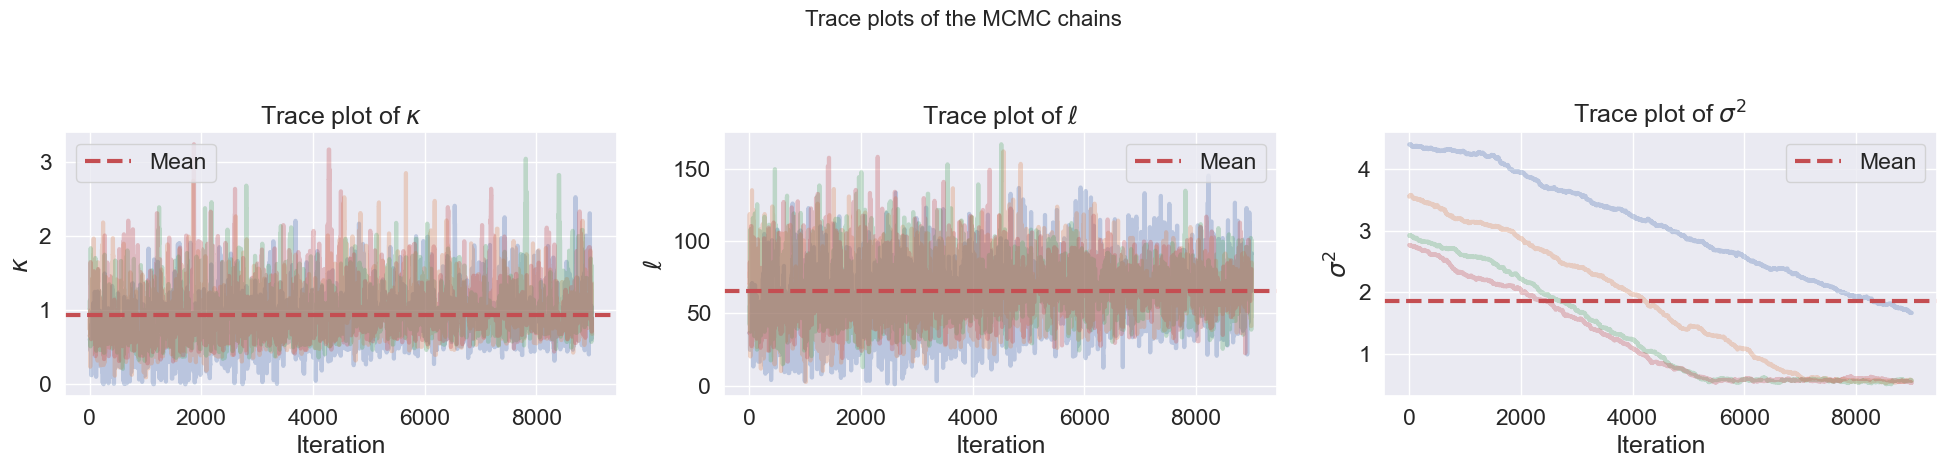

In [61]:



# std of the entire chain and all parameters 
estimated_std = jnp.std(chains, axis=(0, 1))
estimated_variance = jnp.var(chains, axis=(0, 1))
estimated_mean = jnp.mean(chains, axis=(0, 1))

kappa_chain = chains[:, :, 0]
print(f'95%-interval of Kappa:  {np.array2string(jnp.percentile(kappa_chain, jnp.array([2.5, 97.5])), precision=2)}')
kappa_mean = jnp.mean(kappa_chain)
kappa_var = jnp.var(kappa_chain)
kappa_std = jnp.std(kappa_chain)
print(f"Posterior Mean and variance and standard deviation of kappa: {kappa_mean:.4f}, {kappa_var:.4f}, {kappa_std:.4f}")
print("*" * 50)
ell_chain = chains[:, :, 1]
print(f'95%-interval of ell:  {np.array2string(jnp.percentile(ell_chain, jnp.array([2.5, 97.5])), precision=2)}')
ell_mean = jnp.mean(ell_chain)
ell_var = jnp.var(ell_chain)
ell_std = jnp.std(ell_chain)
print(f"Posterior Mean and variance of ell: {jnp.mean(ell_chain):.4f}, {jnp.var(ell_chain):.4f}, {jnp.std(ell_chain):.4f}")
print("*" * 50)
sigma_chain = chains[:, :, 2]
print(f'95%-interval of sigma:  {np.array2string(jnp.percentile(sigma_chain, jnp.array([2.5, 97.5])), precision=2)}')
sigma_mean = jnp.mean(sigma_chain)
sigma_var = jnp.var(sigma_chain)
sigma_std = jnp.std(sigma_chain)
print(f"Posterior Mean and variance and standard deviation of sigma: {sigma_mean:.4f}, {sigma_var:.4f}, {sigma_std:.4f}")
print("*" * 50)

rhat_for_all_params = compute_Rhat(chains)
print(f"Rhat for all params: {rhat_for_all_params}")


total_number_samples = NUM_CHAINS * (NUM_ITER - WARMUP)
print(f"Total number of samples: {total_number_samples}")


S_eff = compute_effective_sample_size(chains)
print(f"Effective sample size: {S_eff}")

R_eff = S_eff / total_number_samples
print(f"R_eff: {R_eff}")

MC_error = estimated_std / jnp.sqrt(S_eff)
print(f"Monte Carlo error: {MC_error}")


fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Trace plots of the MCMC chains', fontsize=16)
axes[0].set_title(r'Trace plot of $\kappa$')
axes[0].plot(chains[:, :, 0].T, alpha=0.3)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel(r'$\kappa$')
axes[0].axhline(kappa_mean, color='r', linestyle='--', label='Mean')
axes[0].legend()
axes[1].set_title(r'Trace plot of $\ell$')
axes[1].plot(chains[:, :, 1].T, alpha=0.3)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel(r'$\ell$')
axes[1].axhline(ell_mean, color='r', linestyle='--', label='Mean')
axes[1].legend()
axes[2].set_title(r'Trace plot of $\sigma^2$')
axes[2].plot(chains[:, :, 2].T, alpha=0.3)
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel(r'$\sigma^2$')
axes[2].axhline(sigma_mean, color='r', linestyle='--', label='Mean')
axes[2].legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('trace_plots.svg', dpi=300)
plt.show()



In [6]:
import jax.numpy as jnp
import numpy as np
from jax import value_and_grad
from jax import random
from scipy.optimize import minimize
import pylab as plt
from scipy.stats import multivariate_normal as mvn
def metropolis(log_target, num_params, tau, num_iter, theta_init=None, seed=0):    
    """ Runs a Metropolis-Hastings sampler 

        Arguments:
        log_target:         function for evaluating the log target distribution, i.e. log \tilde{p}(theta). The function expect a parameter of size num_params.
        num_params:         number of parameters of the joint distribution (integer)
        tau:                standard deviation of the Gaussian proposal distribution (positive real)
        num_iter:           number of iterations (integer)
        theta_init:         vector of initial parameters (np.array with shape (num_params) or None)        
        seed:               seed (integer)

        returns
        thetas              np.array with MCMC samples (np.array with shape (num_iter+1, num_params))
    """ 

    # set initial key
    key = random.PRNGKey(seed)

    # if there is no theta init, it starts with zero
    # theta init is \theta^{k-1}
    if theta_init is None:

        theta_init = jnp.zeros((num_params))
        print(f"Shape of theta init {theta_init.shape} is the same as a number of parameters {num_params}")
    # prepare lists 
    thetas = [theta_init] # list to store all samples, starting with the initial 
    accepts = [] # list of accepted proposals 
    log_p_theta = log_target(theta_init) # log probability of the initial position 

    for k in range(num_iter):
        
        

        # update keys: key_proposal for sampling proposal distribution and key_accept for deciding whether to accept or reject.
        key, key_proposal, key_accept = random.split(key, num=3)

        ##############################################
        # Your solution goes here
        ##############################################
        # Get the current state theta^{(k)} from the end of the list 
        theta_current = thetas[-1] # current position of the chain, \theta^{k-1}
        
        # 1. Propose a new state theta' ~ q(theta' | theta_current)
        # Draw from N(theta_current, tau^2 * I)
        noise = random.normal(key_proposal, shape=(num_params))
        theta_proposal = theta_current + tau * noise
        
        log_p_theta_proposal = log_target(theta_proposal)
        
        log_acceptance_ratio = log_p_theta_proposal - log_p_theta 
        
        u = random.uniform(key_accept)
        
        accept = jnp.log(u) < jnp.minimum(0.0, log_acceptance_ratio)
        
        if accept.all():
            thetas.append(theta_proposal)
            log_p_theta = log_p_theta_proposal
            accepts.append(1.)
        else: 
            thetas.append(theta_current)
            accepts.append(0)
        
        

        ##############################################
        # End of solution
        ##############################################

    print('Acceptance ratio: %3.2f' % jnp.mean(jnp.array(accepts)))

    # return as np.array
    thetas = jnp.stack(thetas)

    # check dimensions and return
    assert thetas.shape == (num_iter+1, num_params), f'The shape of thetas was expected to be ({num_iter+1}, {num_params}), but the actual shape was {thetas.shape}. Please check your code.'
    return thetas

In [4]:
data = jnp.load('data_assignment3.npz')

print(data)

x, y = data['x'], data['t']

def log_normal(x, mu, sigma):
    return -0.5 * jnp.log(2.0 * jnp.pi * sigma**2) - (x - mu)**2 / (2.0 * sigma**2)

def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))


def log_halfnormal(x, loc, scale=1.0):
    """Log-pdf of half-normal 𝒩₊(0,scale²)."""
    return jnp.log(2.0) + norm.logpdf(x, loc=loc, scale=scale)


def hyperpriots(thetas):
    w0 = thetas[0]
    w1 = thetas[1]
    v = thetas[2]
    tau = thetas[3]
    sigma_0 = thetas[4]
    sigma_1 = thetas[5]
    
    if thetas[3] <= 0 or thetas[4] <= 0 or thetas[5] <= 0:
        return -jnp.inf
    

    
    log_hyp_prior = log_normal(w0, 0, tau**2) + log_normal(w1, 0, tau**2) + log_normal(v, 0, tau**2) + log_halfnormal(tau, 0, 1) + log_halfnormal(sigma_0, 0, 1) + log_halfnormal(sigma_1, 0, 1)
    return log_hyp_prior


log_joint = lambda thetas: hyperpriots(thetas) + jnp.sum(log_normal(y, thetas[0] * x, thetas[4]) * (1 - sigmoid(thetas[2] * x)) + log_normal(y, thetas[1] * x, thetas[5]) * sigmoid(thetas[2] * x))

NpzFile 'data_assignment3.npz' with keys: x, t


In [5]:
NUM_ITER   = 10**4          
THETA_INIT = jnp.array([0.0, 0.0, 0.0, 1.0, 1.0, 1.0])  
TAU        = 0.1
NUM_PARAMS = len(THETA_INIT)

samples = metropolis(log_target = log_joint, num_params = NUM_PARAMS, tau=TAU, num_iter = NUM_ITER, theta_init = THETA_INIT, seed = 0)

Acceptance ratio: 0.35


NameError: name 'samples' is not defined

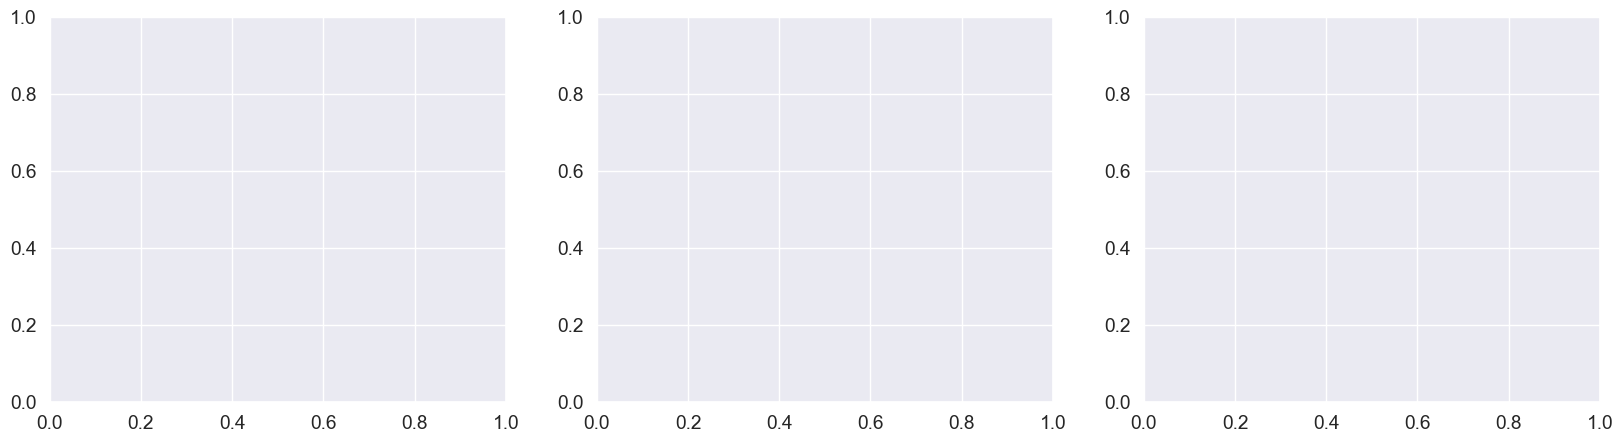

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].plot(samples[:, 0], lw=0.5)
axes[1].plot(samples[:, 1], lw=0.5)
axes[2].plot(samples[:, 2], lw=0.5)

plt.show()

               Experiment Setup     T3
0                  Random Noise  30.00
1                   Ovis SD 128   0.00
2                   Ovis SD 248  17.82
3  Ovis SDXL 128 (no text enc.)   1.00
4  Ovis SDXL 128 (no text enc.)   2.00
5     Ovis SDXL 128 (tech enc.)   3.00
6     Ovis SDXL 248 (tech enc.)   4.00
               Experiment Setup Test  Latency in ms
0                  Random Noise   T3          30.00
1                   Ovis SD 128   T3           0.00
2                   Ovis SD 248   T3          17.82
3  Ovis SDXL 128 (no text enc.)   T3           1.00
4  Ovis SDXL 128 (no text enc.)   T3           2.00
5     Ovis SDXL 128 (tech enc.)   T3           3.00
6     Ovis SDXL 248 (tech enc.)   T3           4.00


C:\Users\Petrb\AppData\Local\Temp\ipykernel_38700\2364262248.py:49: UserWarning: 
The palette list has fewer values (3) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax1 = sns.barplot(x="Test", y="Latency in ms",
C:\Users\Petrb\AppData\Local\Temp\ipykernel_38700\2364262248.py:53: UserWarning: 
The palette list has fewer values (3) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax2 = sns.barplot(x="Test", y="Latency in ms",


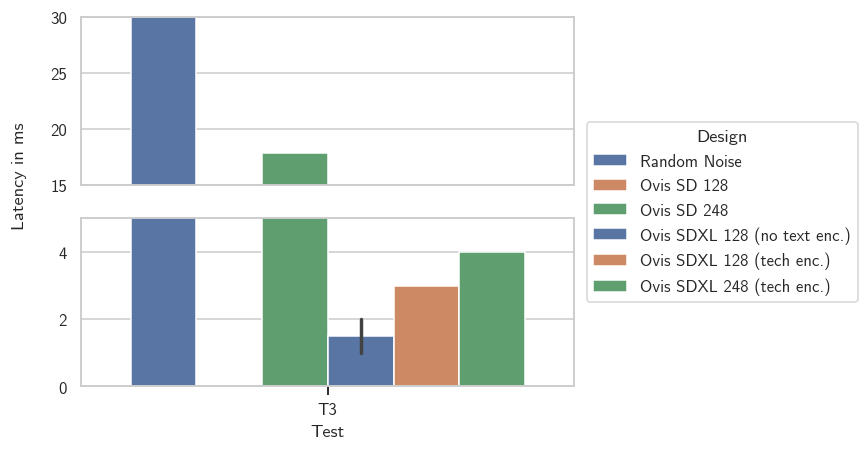

In [34]:


# import seaborn, pyplot (for plotting), and pandas (to build the dataframe)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



     
# input data
data = {"Experiment Setup":  ["Random Noise", "Ovis SD 128", "Ovis SD 248", "Ovis SDXL 128 (no text enc.)", "Ovis SDXL 128 (no text enc.)"  ,"Ovis SDXL 128 (tech enc.)", "Ovis SDXL 248 (tech enc.)",],
        "T3": [30.00, 0.00, 17.82, 1.00, 2.00, 3.00, 4.00]}

# make a dataframe
data = pd.DataFrame(
    data, columns=["Experiment Setup", "T3"])

print(data)


# transform dataframe

data_M = pd.melt(data, id_vars="Experiment Setup", var_name="Test",
                  value_name="Latency in ms")

print(data_M)




# set style for seaborn plot
sns.set(style="whitegrid", font="CMU Sans Serif")
# create a color palette (we only have three different colors for the three different tests T1...T3)
pal = sns.color_palette(n_colors=3)


# let's create a figure for our two plots to live in
# we need a lower part (anything below the cutoff), which will be ax2
# and an upper part (anything above the cutoff) which will be ax1
# because we have only two plots above each other, we set ncols=1 and nrows=2
# also, they should share an x axis, which is why we set sharex=True
f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2,
                             sharex=True)

# we want the "Test" to appear on the x axis as individual parameters
# "Latency in ms" should be what is shown on the y axis as a value
# hue should be the "Experiment Setup"
# this will result three ticks on the x axis with X1...X3 and each with three bars for T1...T3
# (you could turn this around if you need to, depending on what kind of data you want to show)
ax1 = sns.barplot(x="Test", y="Latency in ms",
                  hue="Experiment Setup", data=data_M, palette=pal, ax=ax1)

# we basically do the same thing again for the second plot
ax2 = sns.barplot(x="Test", y="Latency in ms",
                  hue="Experiment Setup", data=data_M, palette=pal, ax=ax2)

# here is the fun part: setting the limits for the individual y axis
# the upper part (ax1) should show only values from 250 to 400
# the lower part (ax2) should only show 0 to 150
# you can define your own limits, but the range (150) should be the same so scale is the same across both plots
# it could be possible to use a different range and then adjust plot height but who knows how that works
ax1.set_ylim(15, 30)
ax2.set_ylim(0, 5)

# the upper part does not need its own x axis as it shares one with the lower part
ax1.get_xaxis().set_visible(False)

# by default, each part will get its own "Latency in ms" label, but we want to set a common for the whole figure
# first, remove the y label for both subplots
ax1.set_ylabel("")
ax2.set_ylabel("")
# then, set a new label on the plot (basically just a piece of text) and move it to where it makes sense (requires trial and error)
f.text(0.05, 0.55, "Latency in ms", va="center", rotation="vertical")

# by default, seaborn also gives each subplot its own legend, which makes no sense at all
# soe remove both default legends first
ax1.get_legend().remove()
ax2.get_legend().remove()
# then create a new legend and put it to the side of the figure (also requires trial and error)
ax2.legend(loc=(1.025, 0.5), title="Design")

# let's put some ticks on the top of the upper part and bottom of the lower part for style
ax1.xaxis.tick_top()
ax2.xaxis.tick_bottom()

# finally, adjust everything a bit to make it prettier (this just moves everything, best to try and iterate)
f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)

plt.show()





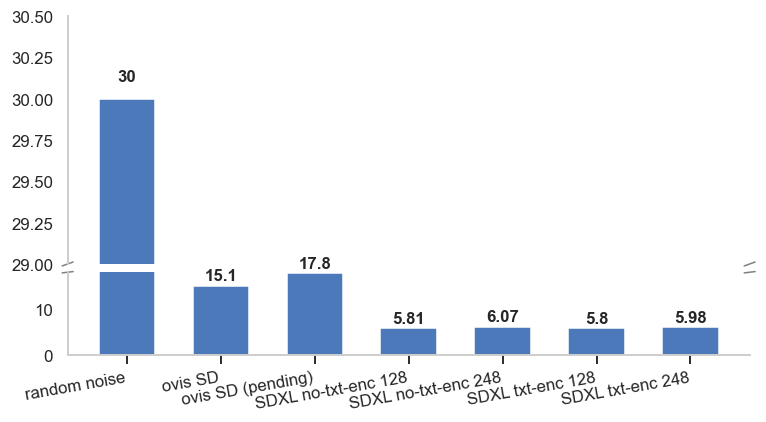

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# ── 1. Data ─────────────────────────────────────────────────────────────────
models = [
    "random noise",
    "ovis SD",
    "ovis SD (pending)",
    "SDXL no-txt-enc 128",
    "SDXL no-txt-enc 248",
    "SDXL txt-enc 128",
    "SDXL txt-enc 248"
]

fid_scores = [
    30.00,      # random noise
    15.05,
    17.82,     # pending
    5.81,
    6.066,
    5.7991,
    5.9754
]

# ── 2. Define your “break” ───────────────────────────────────────────────────
# Everything ≤ cut_lower is shown on the bottom axis;
# everything ≥ cut_upper is on the top axis.
cut_lower = 18
cut_upper = 29

# ── 3. Figure + two shared-x axes ────────────────────────────────────────────
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    sharex=True,
    figsize=(8, 4),
    gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05}
)
x = np.arange(len(models))
bar_width = 0.6

# ── 4. Plot the bars on both axes ────────────────────────────────────────────
for ax in (ax_top, ax_bot):
    for xi, score in zip(x, fid_scores):
        if np.isnan(score):
            # placeholder: zero-height, hatched grey bar
            ax.bar(xi, 0,
                   width=bar_width,
                   color='lightgray',
                   edgecolor='dimgray',
                   hatch='///')
        else:
            # full‐height bar; parts outside the axis limits are clipped away
            ax.bar(xi, score,
                   width=bar_width,
                   color='#4C79B9')

# ── 5. Set the y-limits to carve out the gap ─────────────────────────────────
ax_bot.set_ylim(0, cut_lower)
ax_top.set_ylim(cut_upper, max([v for v in fid_scores if not np.isnan(v)]) + 2)

# grab each span and use a small fraction as our text offset
bot_ylim = ax_bot.get_ylim()
top_ylim = ax_top.get_ylim()
bot_offset = (bot_ylim[1] - bot_ylim[0]) * 0.03   # 3% of bottom‐axis height
top_offset = (top_ylim[1] - top_ylim[0]) * 0.03   # 3% of top‐axis height

# ── 6. Clean up spines & ticks ───────────────────────────────────────────────
for ax in (ax_top, ax_bot):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
ax_top.spines['bottom'].set_visible(False)
ax_bot.spines['top'].set_visible(False)
ax_top.tick_params(labelbottom=False)   # no x-labels on top
ax_bot.xaxis.tick_bottom()

# ── 7. Draw the little “zig-zags” to show the break ─────────────────────────
d = .008  # size of the diagonal crack in axes coords
# top
kwargs = dict(color='gray', clip_on=False, linewidth=1)
ax_top.plot((-d, +d), (-d, +d), transform=ax_top.transAxes, **kwargs)
ax_top.plot((1-d, 1+d), (-d, +d), transform=ax_top.transAxes, **kwargs)
# bottom
ax_bot.plot((-d, +d), (1-d, 1+d), transform=ax_bot.transAxes, **kwargs)
ax_bot.plot((1-d, 1+d), (1-d, 1+d), transform=ax_bot.transAxes, **kwargs)

# ── 8. Annotate each bar with its FID or “TBD” ───────────────────────────────
for xi, score in zip(x, fid_scores):
    if np.isnan(score):
        ax_bot.text(xi, 0.3, "TBD",
                    ha='center', va='bottom',
                    fontsize=10, fontstyle='italic', color='dimgray')
    elif score <= cut_lower:
        ax_bot.text(xi, score + bot_offset,
                    f"{score:.3g}",
                    ha='center', va='bottom',
                    fontsize=11, weight='bold')
    else:
        ax_top.text(xi, score + top_offset,
                    f"{score:.3g}",
                    ha='center', va='bottom',
                    fontsize=11, weight='bold')

# ── 9. Final polish ──────────────────────────────────────────────────────────
ax_bot.set_xticks(x)
ax_bot.set_xticklabels(models, rotation=10, ha='right')
#ax_bot.set_ylabel("FID ↓ (lower is better)")
# turn grid to false 
ax_top.grid(False)
ax_top.set_ylim(29, 30.5)
ax_bot.grid(False)
#plt.tight_layout()
# set y limint 
plt.savefig('bar_plot.svg', dpi=300)
plt.show()



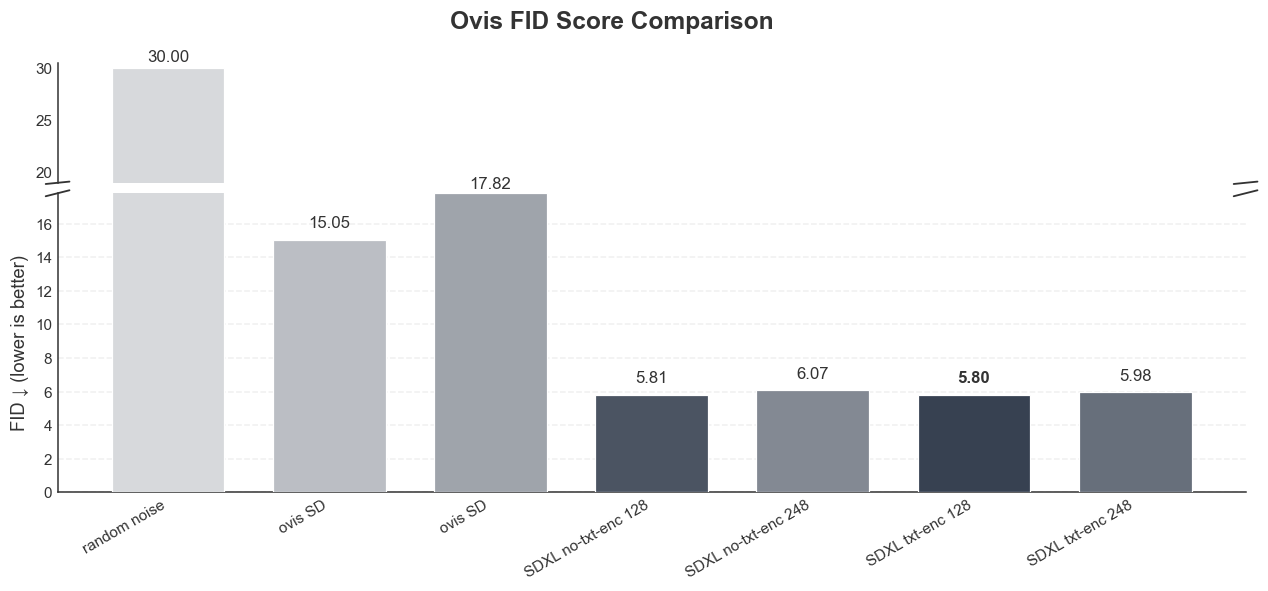

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# ── 1. Data ─────────────────────────────────────────────────────────────────
models = [
    "random noise",
    "ovis SD",
    "ovis SD",
    "SDXL no-txt-enc 128",
    "SDXL no-txt-enc 248",
    "SDXL txt-enc 128",
    "SDXL txt-enc 248"
]

fid_scores = [
    30.00,      # random noise
    15.05,
    17.82,     # pending
    5.81,
    6.066,
    5.7991,    # Best model (lowest score)
    5.9754
]

# ── 2. Define your "break" ───────────────────────────────────────────────────
cut_lower = 17.81
cut_upper = 19

# ── 3. Create a professional color palette ──────────────────────────────────────
# Find the best model (lowest FID score)
best_model_idx = np.argmin(fid_scores)

# Define colors (fix deprecated get_cmap warning)
# Use a predefined color palette instead
colors = [
    '#d7d9dc',      # Random noise
    '#bbbec4',      # ovis SD
    '#9fa4ab',      # ovis SD (pending)
    '#4b5462',      # SDXL no-txt-enc 128
    '#838993',      # SDXL no-txt-enc 248
    '#374151',      # Best model (SDXL txt-enc 128) - darkest
    '#676f7b'       # SDXL txt-enc 248
]

# ── 4. Figure + two shared-x axes with improved styling ────────────────────────
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': False,
    'figure.facecolor': 'white',
})

fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    sharex=True,
    figsize=(12, 6),
    gridspec_kw={'height_ratios': [1, 2.5], 'hspace': 0.05}
)

x = np.arange(len(models))
bar_width = 0.7

# ── 5. Plot the bars on both axes with enhanced styling ────────────────────────
for i, (xi, score) in enumerate(zip(x, fid_scores)):
    if np.isnan(score):
        # placeholder: zero-height, hatched grey bar
        for ax in (ax_top, ax_bot):
            ax.bar(xi, 0,
                   width=bar_width,
                   color='lightgray',
                   edgecolor='dimgray',
                   hatch='///')
    else:
        # full‐height bar; parts outside the axis limits are clipped away
        for ax in (ax_top, ax_bot):
            ax.bar(xi, score,
                   width=bar_width,
                   color=colors[i],
                   edgecolor='white',
                   linewidth=0.8,
                   zorder=3)  # Make sure bars are above grid lines

# ── 6. Set the y-limits to carve out the gap ─────────────────────────────────
ax_bot.set_ylim(0, cut_lower)
ax_top.set_ylim(cut_upper, max([v for v in fid_scores if not np.isnan(v)]) + 0.5)

# grab each span and use a small fraction as our text offset
bot_ylim = ax_bot.get_ylim()
top_ylim = ax_top.get_ylim()
bot_offset = (bot_ylim[1] - bot_ylim[0]) * 0.03   # 3% of bottom‐axis height
top_offset = (top_ylim[1] - top_ylim[0]) * 0.03   # 3% of top‐axis height

# ── 7. Clean up spines & ticks with enhanced styling ───────────────────────────
for ax in (ax_top, ax_bot):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('#333333')
    ax.spines['bottom'].set_color('#333333')
    ax.tick_params(colors='#333333')

ax_top.spines['bottom'].set_visible(False)
ax_bot.spines['top'].set_visible(False)
ax_top.tick_params(labelbottom=False)   # no x-labels on top
ax_bot.xaxis.tick_bottom()

# Add subtle grid lines in the y direction only
ax_bot.grid(axis='y', linestyle='--', alpha=0.3, color='#cccccc', zorder=0)

# ── 8. Draw the little "zig-zags" to show the break with enhanced styling ─────────
d = .01  # size of the diagonal crack in axes coords
# top
kwargs = dict(color='#333333', clip_on=False, linewidth=1.2)
ax_top.plot((-d, +d), (-d, +d), transform=ax_top.transAxes, **kwargs)
ax_top.plot((1-d, 1+d), (-d, +d), transform=ax_top.transAxes, **kwargs)
# bottom
ax_bot.plot((-d, +d), (1-d, 1+d), transform=ax_bot.transAxes, **kwargs)
ax_bot.plot((1-d, 1+d), (1-d, 1+d), transform=ax_bot.transAxes, **kwargs)

# ── 9. Annotate each bar with its FID score with enhanced styling ───────────────
for i, (xi, score) in enumerate(zip(x, fid_scores)):
    # Label styling
    label_color = '#333333'
    font_weight = 'bold' if i == best_model_idx else 'normal'
    
    if np.isnan(score):
        ax_bot.text(xi, 0.3, "TBD",
                    ha='center', va='bottom',
                    fontsize=10, fontstyle='italic', color='dimgray')
    elif score <= cut_lower:
        ax_bot.text(xi, score + bot_offset,
                    f"{score:.2f}",
                    ha='center', va='bottom',
                    fontsize=11, fontweight=font_weight, color=label_color)
    else:
        ax_top.text(xi, score + top_offset,
                    f"{score:.2f}",
                    ha='center', va='bottom',
                    fontsize=11, fontweight=font_weight, color=label_color)
        
    # Highlight the best model with a marker symbol (fix missing font warning)
    # Use a marker that's available in standard fonts
#    if i == best_model_idx:
#        if score <= cut_lower:
#            ax_bot.text(xi, score + bot_offset * 6, "▼",  # Down arrow instead of star
#                       ha='center', va='bottom',
#                       fontsize=14, color='#1a365d')
#        else:
#            ax_top.text(xi, score + top_offset * 6, "▼",  # Down arrow instead of star
#                       ha='center', va='bottom',
#                       fontsize=14, color='#1a365d')

# ── 10. Final polish with enhanced styling ──────────────────────────────────────
ax_bot.set_xticks(x)
ax_bot.set_xticklabels(models, rotation=30, ha='right')
ax_bot.set_ylabel("FID ↓ (lower is better)", fontsize=12, color='#333333')

# Add a title
fig.suptitle('Ovis FID Score Comparison', fontsize=16, fontweight='bold', color='#333333', y=0.98)

# Add a subtle text indicating the best model (fix missing font warning)
#plt.figtext(0.02, 0.02, "▼ indicates best model (lowest FID score)", 
#            fontsize=9, color='#1a365d', ha='left')

# Adjust layout
plt.subplots_adjust(left=0.08, right=0.98, top=0.9, bottom=0.25)

plt.savefig('enhanced_ovis_plot.svg', dpi=300, bbox_inches='tight')
plt.savefig('enhanced_ovis_plot.png', dpi=300, bbox_inches='tight')
plt.show()

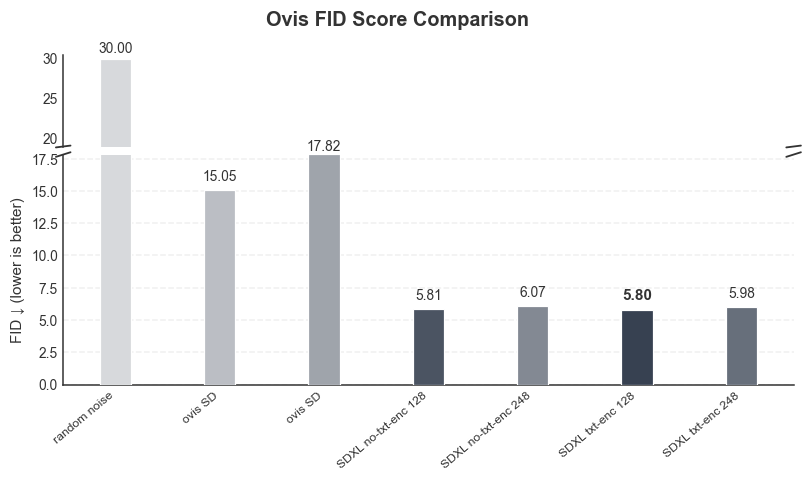

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# ── 1. Data ─────────────────────────────────────────────────────────────────
models = [
    "random noise",
    "ovis SD",
    "ovis SD",
    "SDXL no-txt-enc 128",
    "SDXL no-txt-enc 248",
    "SDXL txt-enc 128",
    "SDXL txt-enc 248"
]

fid_scores = [
    30.00,      # random noise
    15.05,
    17.82,     # pending
    5.81,
    6.066,
    5.7991,    # Best model (lowest score)
    5.9754
]

# ── 2. Define your "break" ───────────────────────────────────────────────────
cut_lower = 17.81
cut_upper = 19

# ── 3. Define colors ──────────────────────────────────────────────────────────
colors = [
    '#d7d9dc',      # Random noise
    '#bbbec4',      # ovis SD
    '#9fa4ab',      # ovis SD (pending)
    '#4b5462',      # SDXL no-txt-enc 128
    '#838993',      # SDXL no-txt-enc 248
    '#374151',      # Best model (SDXL txt-enc 128) - darkest
    '#676f7b'       # SDXL txt-enc 248
]

# ── 4. Figure setup with more compact dimensions ────────────────────────────────
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 13,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': False,
    'figure.facecolor': 'white',
})

# Create a figure with reduced width
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    sharex=True,
    figsize=(8, 5),  # Significantly narrower figure
    gridspec_kw={'height_ratios': [1, 2.5], 'hspace': 0.05}
)

# Make bars much narrower and compress x-axis
x = np.arange(len(models))
bar_width = 0.3  # Very narrow bars

# ── 5. Plot the bars on both axes ────────────────────────────────────────────
for i, (xi, score) in enumerate(zip(x, fid_scores)):
    if np.isnan(score):
        # placeholder: zero-height, hatched grey bar
        for ax in (ax_top, ax_bot):
            ax.bar(xi, 0,
                   width=bar_width,
                   color='lightgray',
                   edgecolor='dimgray',
                   hatch='///')
    else:
        # full‐height bar; parts outside the axis limits are clipped away
        for ax in (ax_top, ax_bot):
            ax.bar(xi, score,
                   width=bar_width,
                   color=colors[i],
                   edgecolor='white',
                   linewidth=0.8,
                   zorder=3)  # Make sure bars are above grid lines

# ── 6. Set the y-limits to carve out the gap ─────────────────────────────────
ax_bot.set_ylim(0, cut_lower)
ax_top.set_ylim(cut_upper, max([v for v in fid_scores if not np.isnan(v)]) + 0.5)

# Set tighter x-axis limits to compress the chart horizontally
ax_bot.set_xlim(-0.5, len(models) - 0.5)

# Calculate offsets for labels
bot_ylim = ax_bot.get_ylim()
top_ylim = ax_top.get_ylim()
bot_offset = (bot_ylim[1] - bot_ylim[0]) * 0.03
top_offset = (top_ylim[1] - top_ylim[0]) * 0.03

# ── 7. Clean up spines & ticks ───────────────────────────────────────────────
for ax in (ax_top, ax_bot):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('#333333')
    ax.spines['bottom'].set_color('#333333')
    ax.tick_params(colors='#333333')

ax_top.spines['bottom'].set_visible(False)
ax_bot.spines['top'].set_visible(False)
ax_top.tick_params(labelbottom=False)
ax_bot.xaxis.tick_bottom()

# Add subtle grid lines
ax_bot.grid(axis='y', linestyle='--', alpha=0.3, color='#cccccc', zorder=0)

# ── 8. Draw break indicators ───────────────────────────────────────────────────
d = .01  # size of the diagonal crack
kwargs = dict(color='#333333', clip_on=False, linewidth=1.2)
ax_top.plot((-d, +d), (-d, +d), transform=ax_top.transAxes, **kwargs)
ax_top.plot((1-d, 1+d), (-d, +d), transform=ax_top.transAxes, **kwargs)
ax_bot.plot((-d, +d), (1-d, 1+d), transform=ax_bot.transAxes, **kwargs)
ax_bot.plot((1-d, 1+d), (1-d, 1+d), transform=ax_bot.transAxes, **kwargs)

# ── 9. Add value labels to bars ─────────────────────────────────────────────────
for i, (xi, score) in enumerate(zip(x, fid_scores)):
    # Label styling
    is_best = (i == np.argmin(fid_scores))
    label_color = '#333333'
    font_weight = 'bold' if is_best else 'normal'
    font_size = 10 if is_best else 9  # Smaller font size for more compact display
    
    # Position labels
    if np.isnan(score):
        ax_bot.text(xi, 0.3, "TBD",
                   ha='center', va='bottom',
                   fontsize=8, fontstyle='italic', color='dimgray')
    elif score <= cut_lower:
        ax_bot.text(xi, score + bot_offset,
                   f"{score:.2f}",
                   ha='center', va='bottom',
                   fontsize=font_size, fontweight=font_weight, color=label_color)
    else:
        ax_top.text(xi, score + top_offset,
                   f"{score:.2f}",
                   ha='center', va='bottom',
                   fontsize=font_size, fontweight=font_weight, color=label_color)

# ── 10. Final styling ─────────────────────────────────────────────────────────
# Set up the x-ticks
ax_bot.set_xticks(x)

# Arrange labels for better fit in narrow space
ax_bot.set_xticklabels(models, rotation=40, ha='right', fontsize=8)
ax_bot.set_ylabel("FID ↓ (lower is better)", fontsize=10, color='#333333')

# Add title - positioned for narrower chart
fig.suptitle('Ovis FID Score Comparison', fontsize=13, fontweight='bold', color='#333333', y=0.98)

# Adjust layout for maximum narrowness while maintaining readability
plt.subplots_adjust(left=0.12, right=0.95, top=0.9, bottom=0.30)

plt.savefig('narrow_ovis_plot.svg', dpi=300, bbox_inches='tight')
plt.savefig('narrow_ovis_plot.png', dpi=300, bbox_inches='tight')
plt.show()